# Testing MPO

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings('ignore') 
import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Make oracles.

In [2]:
import os

dockstring_dir = f'{path}/dockstring_targets/'
files = os.listdir(dockstring_dir)
configs = sorted([f for f in files if 'conf' in f])
targets = sorted([f for f in files if 'target' in f])

idx = 0
with open(dockstring_dir + configs[idx], 'r') as f:
    config_ = f.readlines()
    config_ = [c.replace('\n', '') for c in config_]
    config_ = [c.split(' = ') for c in config_ if c]
    config_ = {c[0]: float(c[1]) for c in config_}

target = targets[idx]
name = target.split('_')[0]

config_.update({
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
})

from dgym.envs.oracle import DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'search_mode': 'detailed',
    'scoring': 'vina',
    'seed': 5,
    **config_
}

docking_oracle = DockingOracle(
    f'{name} affinity',
    receptor_path=f'{path}/dockstring_targets/{name}_target.pdbqt',
    config=config
)
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = CatBoostOracle('Log S', path='../../dgym-data/models/aqsolcb.model')

# create evaluators
docking_cost_function = ClassicUtilityFunction(
    docking_oracle,
    ideal=(9.5, 13),
    acceptable=(9, 13)
)

log_P_cost_function = ClassicUtilityFunction(
    log_P_oracle,
    ideal=(0.5, 1.85),
    acceptable=(-0.5, 3.5)
)

log_S_cost_function = ClassicUtilityFunction(
    log_S_oracle,
    ideal=(-1, 1),
    acceptable=(-4, 1)
)

assays = [
    docking_oracle,
    log_P_oracle,
    log_S_oracle
]

cost_functions = [
    docking_cost_function,
    log_P_cost_function,
    log_S_cost_function
]

Instantiate designer.

In [3]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [7]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
initial_library = dg.MoleculeCollection(initial_molecules)
initial_library.update_annotations()
library = initial_library

Prepare MPO ranking function.

In [8]:
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def rank_molecules(costs):
    
    costs = np.nan_to_num(costs)

    # Multi-dimensional non-dominated fusion sort
    nds, nds_ranks = NonDominatedSorting().do(
        costs, return_rank=True, only_non_dominated_front=False)
    penalty_sums = np.sum(costs, axis=1)
    fused_ranks = np.lexsort([penalty_sums, nds_ranks]) # prioritizes last column
    
    return fused_ranks.tolist()

Multi-step selection.

In [9]:
import numpy as np
from tqdm.notebook import tqdm

for molecule in library:
    molecule.update_annotations(
        {'timestep': 0, **{a.name: a(molecule) for a in assays}})

costs = np.asarray([cost(library) for cost in cost_functions[:2]]).T
ranking = rank_molecules(costs)
best = ranking

print([cost(library[best]) for cost in cost_functions])
print(best)

for step in tqdm(range(1, 15)):
    
    analogs = []
    for b in best:
        if step % 5 == 2:
            analogs += designer.design(
                library[b], 8, strategy='grow')
        else:
            analogs += designer.design(
                library[b], 8, strategy='replace', temperature=0.0)

    # Get costs
    library += analogs
    costs = np.asarray([cost(library) for cost in cost_functions]).T

    ranking = rank_molecules(costs)
    best = ranking[:5]

    for analog in analogs:
        analog.update_annotations(
            {'timestep': step, **{a.name: a(analog) for a in assays}})

    print(step, costs[best])
    print(step, best)

[array([15.4544008 , 17.40170826, 21.57062825, 23.17561301, 30.27550765]), array([0.23352727, 0.        , 0.        , 0.2767    , 0.        ]), array([0.51901665, 0.25125544, 0.20850015, 0.04183721, 0.        ])]
[1, 0, 2, 3, 4]


  0%|          | 0/14 [00:00<?, ?it/s]

1 [[11.14407623  0.60019394  0.77601131]
 [12.30768384  0.          0.25893247]
 [13.28388028  0.          0.        ]
 [13.16212031  0.14527273  0.41703604]
 [15.3178064   0.          0.4158631 ]]
1 [8, 16, 15, 17, 12]
2 [[ 7.75440025  0.89316364  1.77977244]
 [10.01492763  0.38539394  0.72810942]
 [11.69268457  0.24642424  0.57011929]
 [12.30768384  0.          0.25893247]
 [11.78782713  0.          0.78277505]]
2 [48, 61, 56, 16, 64]
3 [[ 6.98785692  0.38539394  0.74832123]
 [ 7.60497729  0.12854545  0.84862041]
 [ 8.82485128  0.01872727  0.78043346]
 [ 9.78917008  0.38169697  0.56241685]
 [10.21502933  0.          0.52896272]]
3 [85, 112, 88, 107, 98]
4 [[6.01347002e-154 0.00000000e+000 5.02456198e-001]
 [8.43859539e+000 0.00000000e+000 4.98407619e-001]
 [1.06859115e+001 0.00000000e+000 4.77647233e-001]
 [1.09001544e+001 0.00000000e+000 4.41601215e-001]
 [1.18819340e+001 1.72618182e-001 3.03026284e-001]]
4 [151, 117, 87, 93, 141]
5 [[1.20737147e-153 0.00000000e+000 4.17786845e-001]

Exception ignored in: <function tqdm.__del__ at 0x7fe40d735260>
Traceback (most recent call last):
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/tqdm/std.py", line 1144, in __del__
KeyboardInterrupt: 


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1148/869719760.py", line 28, in <module>
    costs = np.asarray([cost(library) for cost in cost_functions]).T
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1148/869719760.py", line 28, in <listcomp>
    costs = np.asarray([cost(library) for cost in cost_functions]).T
                        ^^^^^^^^^^^^^
  File "/home/mrr/dev/chodera/dgym/dgym/envs/utility.py", line 28, in __call__
    input = self.oracle(input)
            ^^^^^^^^^^^^^^^^^^
  File "/home/mrr/dev/chodera/dgym/dgym/envs/oracle.py", line 34, in __call__
    return self.get_predictions(molecules, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/dev/chodera/dgym/dgym/envs/oracle.py", line 56, in get_predictions


# Visualizing results

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Heavy atom count vs. pIC50')

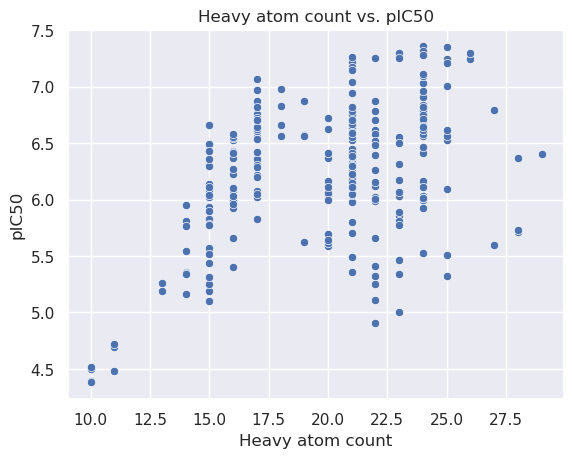

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem.Descriptors import HeavyAtomCount

sns.set()
sns.scatterplot(
    x=[HeavyAtomCount(m.mol) for m in library],
    y=docking_oracle(library),
)

plt.xlabel('Heavy atom count')
plt.ylabel('pIC50')
plt.title('Heavy atom count vs. pIC50')

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

<Figure size 1920x1440 with 0 Axes>

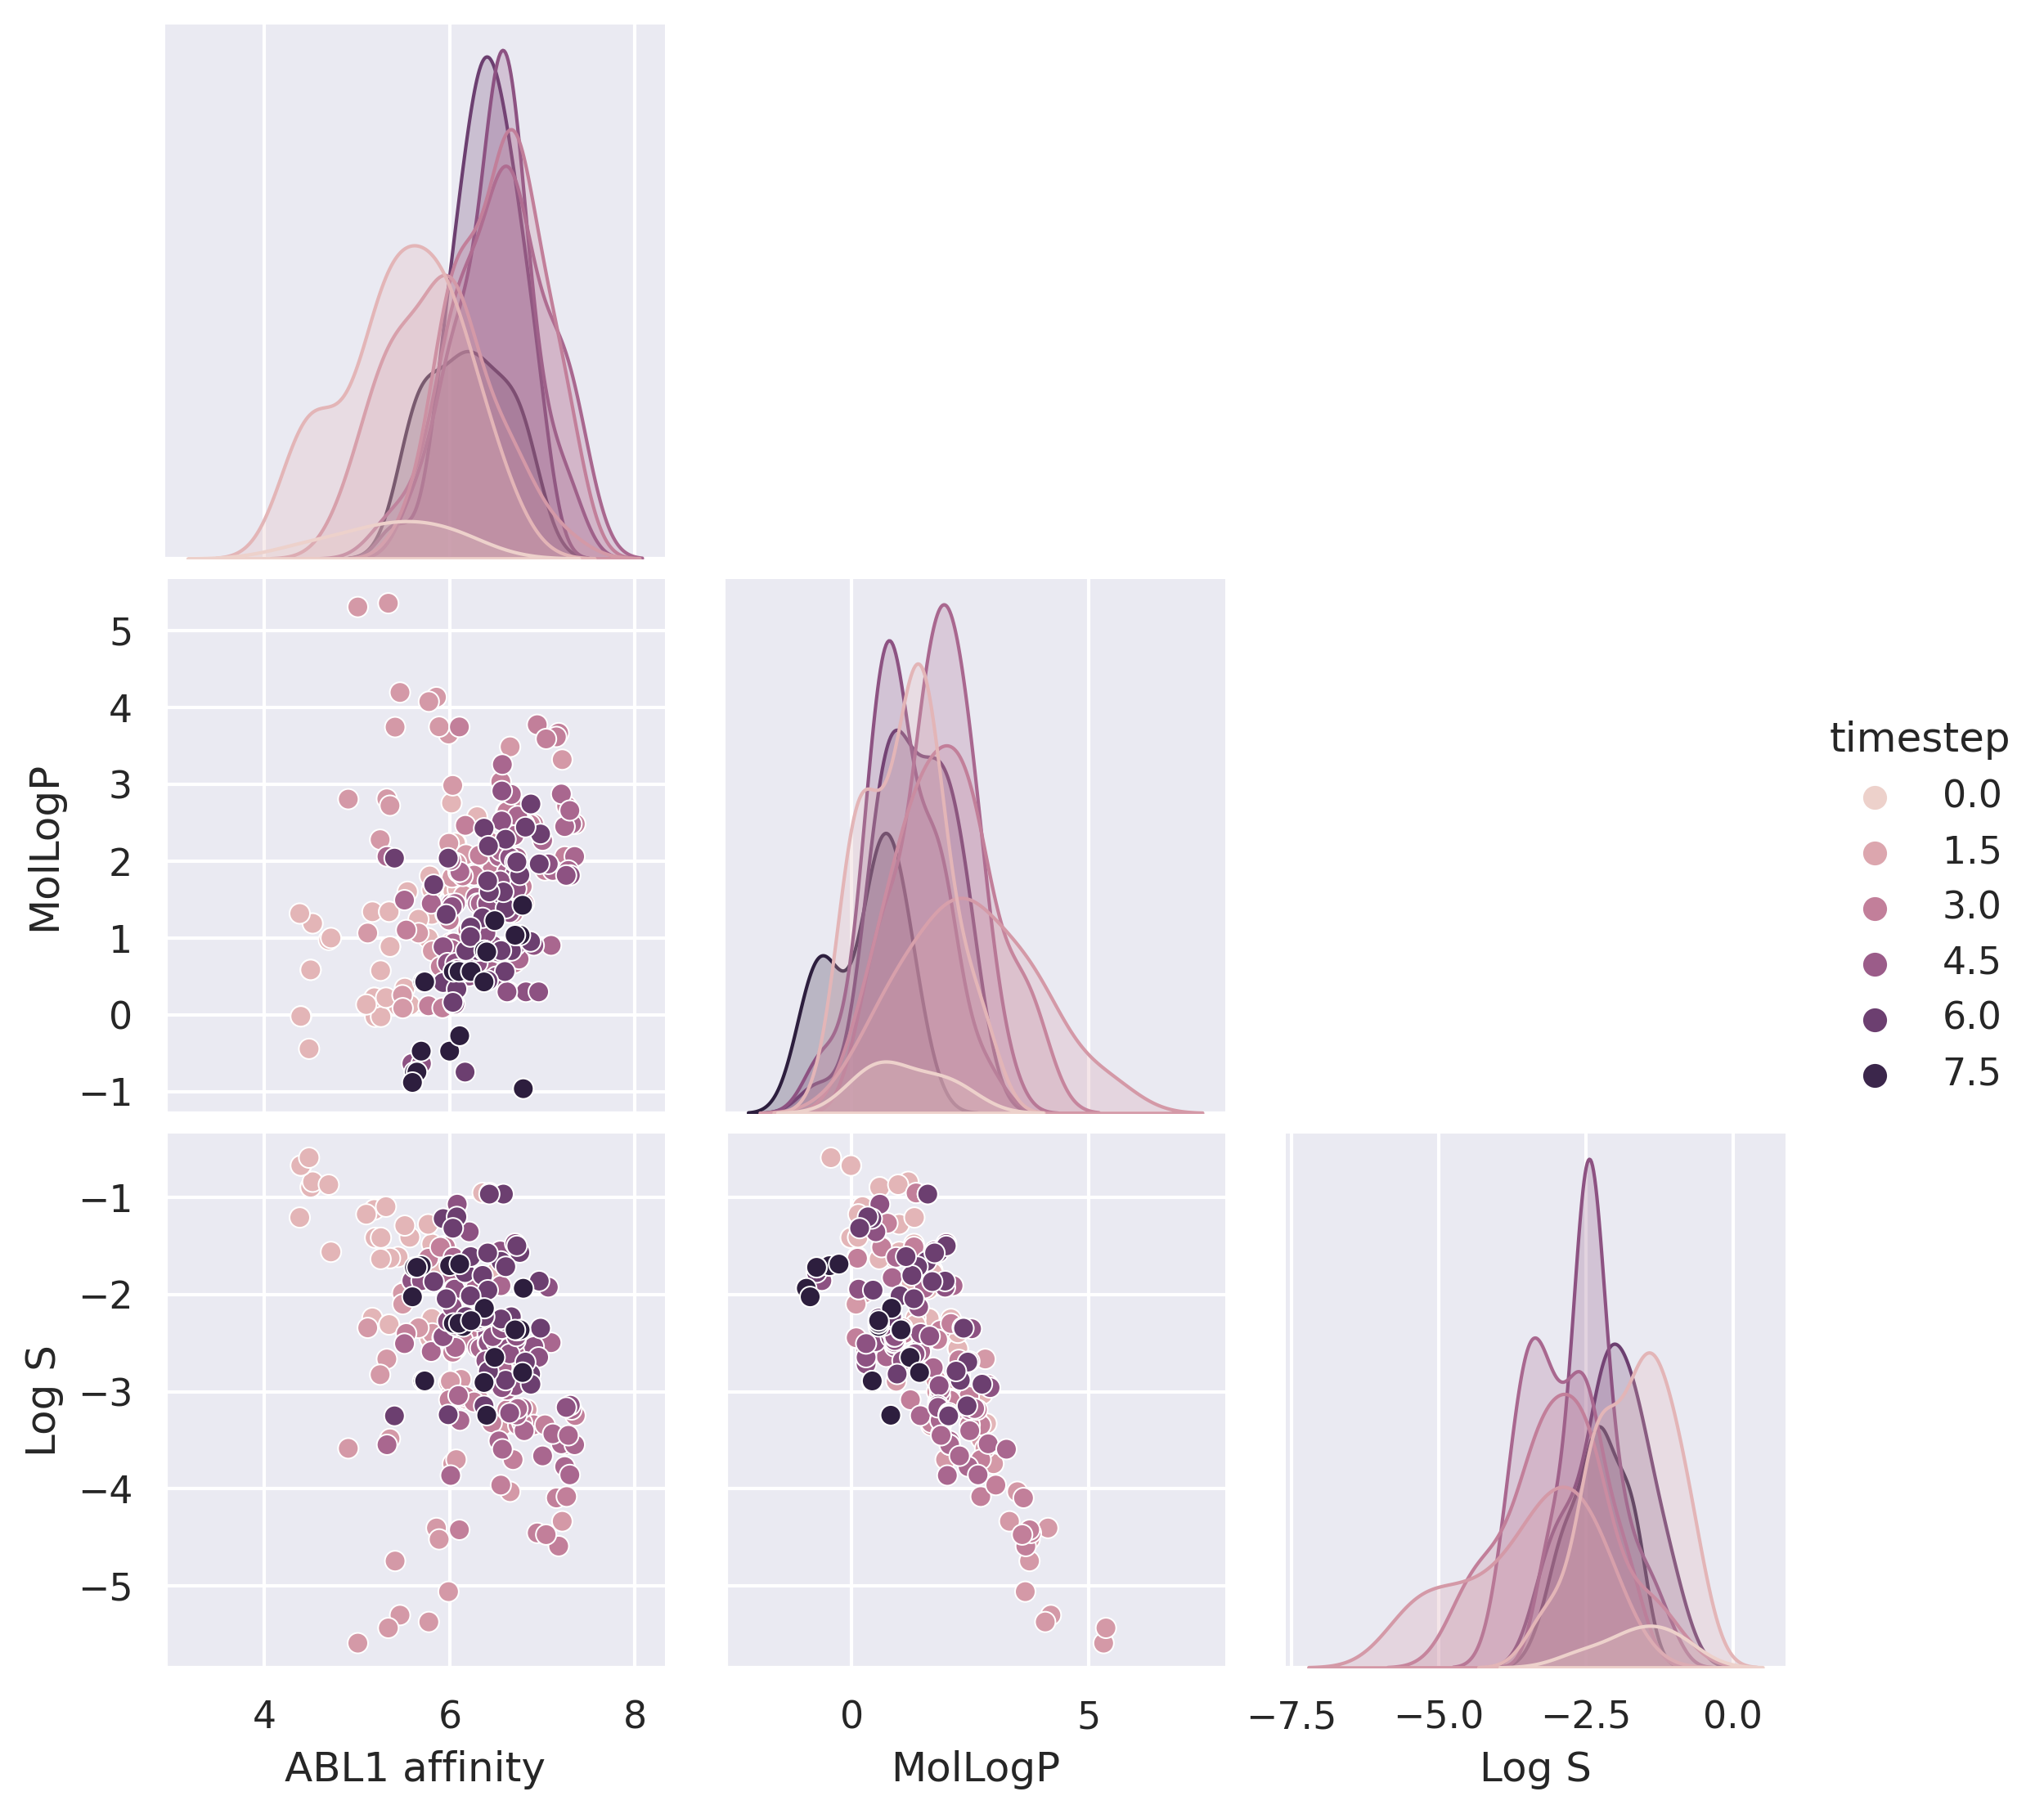

In [28]:
import pandas as pd

plt.figure(dpi=300)

pairplot_df = (
    library.annotations[
        ['ABL1 affinity', 'MolLogP', 'Log S', 'timestep']
    ].map(
        lambda x: x[0] if isinstance(x, list) else x
    ).dropna()
)

sns.set_theme()
g = sns.pairplot(
    pairplot_df,
    corner=True,
    hue='timestep'
)
g.fig.set_dpi(300)

## Visualizing the best across rounds

A trajectory of the best molecule each round.

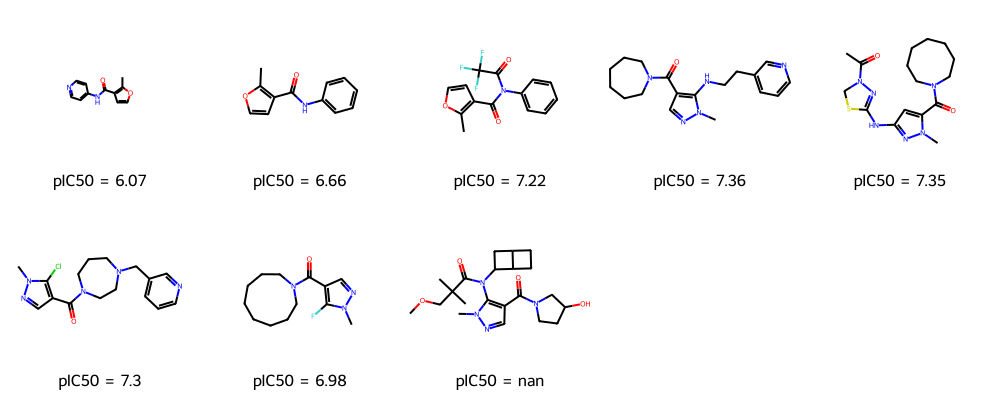

In [30]:
best_across_round = [
    library.annotations.query(f'timestep == {i}')[f'{name} affinity']
    .sort_values(na_position='first')
    .index[-1].item()
    for i in range(int(library.annotations.timestep.max()))
    if library.annotations.query(f'timestep == {i}')[f'{name} affinity'].any()
]

from rdkit.Chem.Draw import MolsToGridImage

get_affinity = lambda idx: library[idx][f'{name} affinity'][0]
MolsToGridImage(
    [m.mol for m in library[best_across_round]],
    molsPerRow=5,
    legends=[f'pIC50 = {round(get_affinity(b), 2)}' for b in best_across_round]
)

A trajectory of the best molecule.

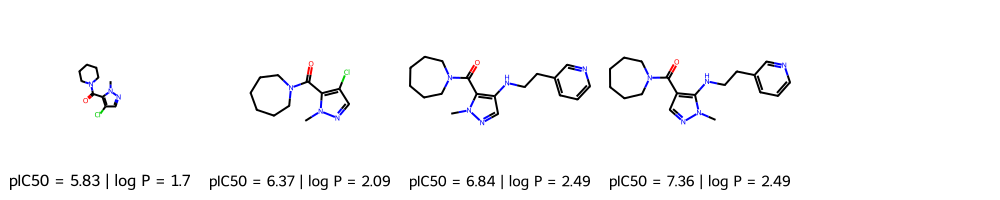

In [31]:
mol = library[np.nanargmax(docking_oracle(library)).item()]
milestones = [mol]
while mol.inspiration:
    milestones.append(mol.inspiration)
    mol = mol.inspiration
    
milestones = list(reversed(milestones))

MolsToGridImage(
    [m.mol for m in milestones],
    molsPerRow=5,
    legends=[f'pIC50 = {round(docking_oracle(m)[0], 2)} | log P = {round(log_P_oracle(m)[0], 2)}' for m in milestones]
)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

Text(0.5, 1.0, 'New compounds synthesized each round')

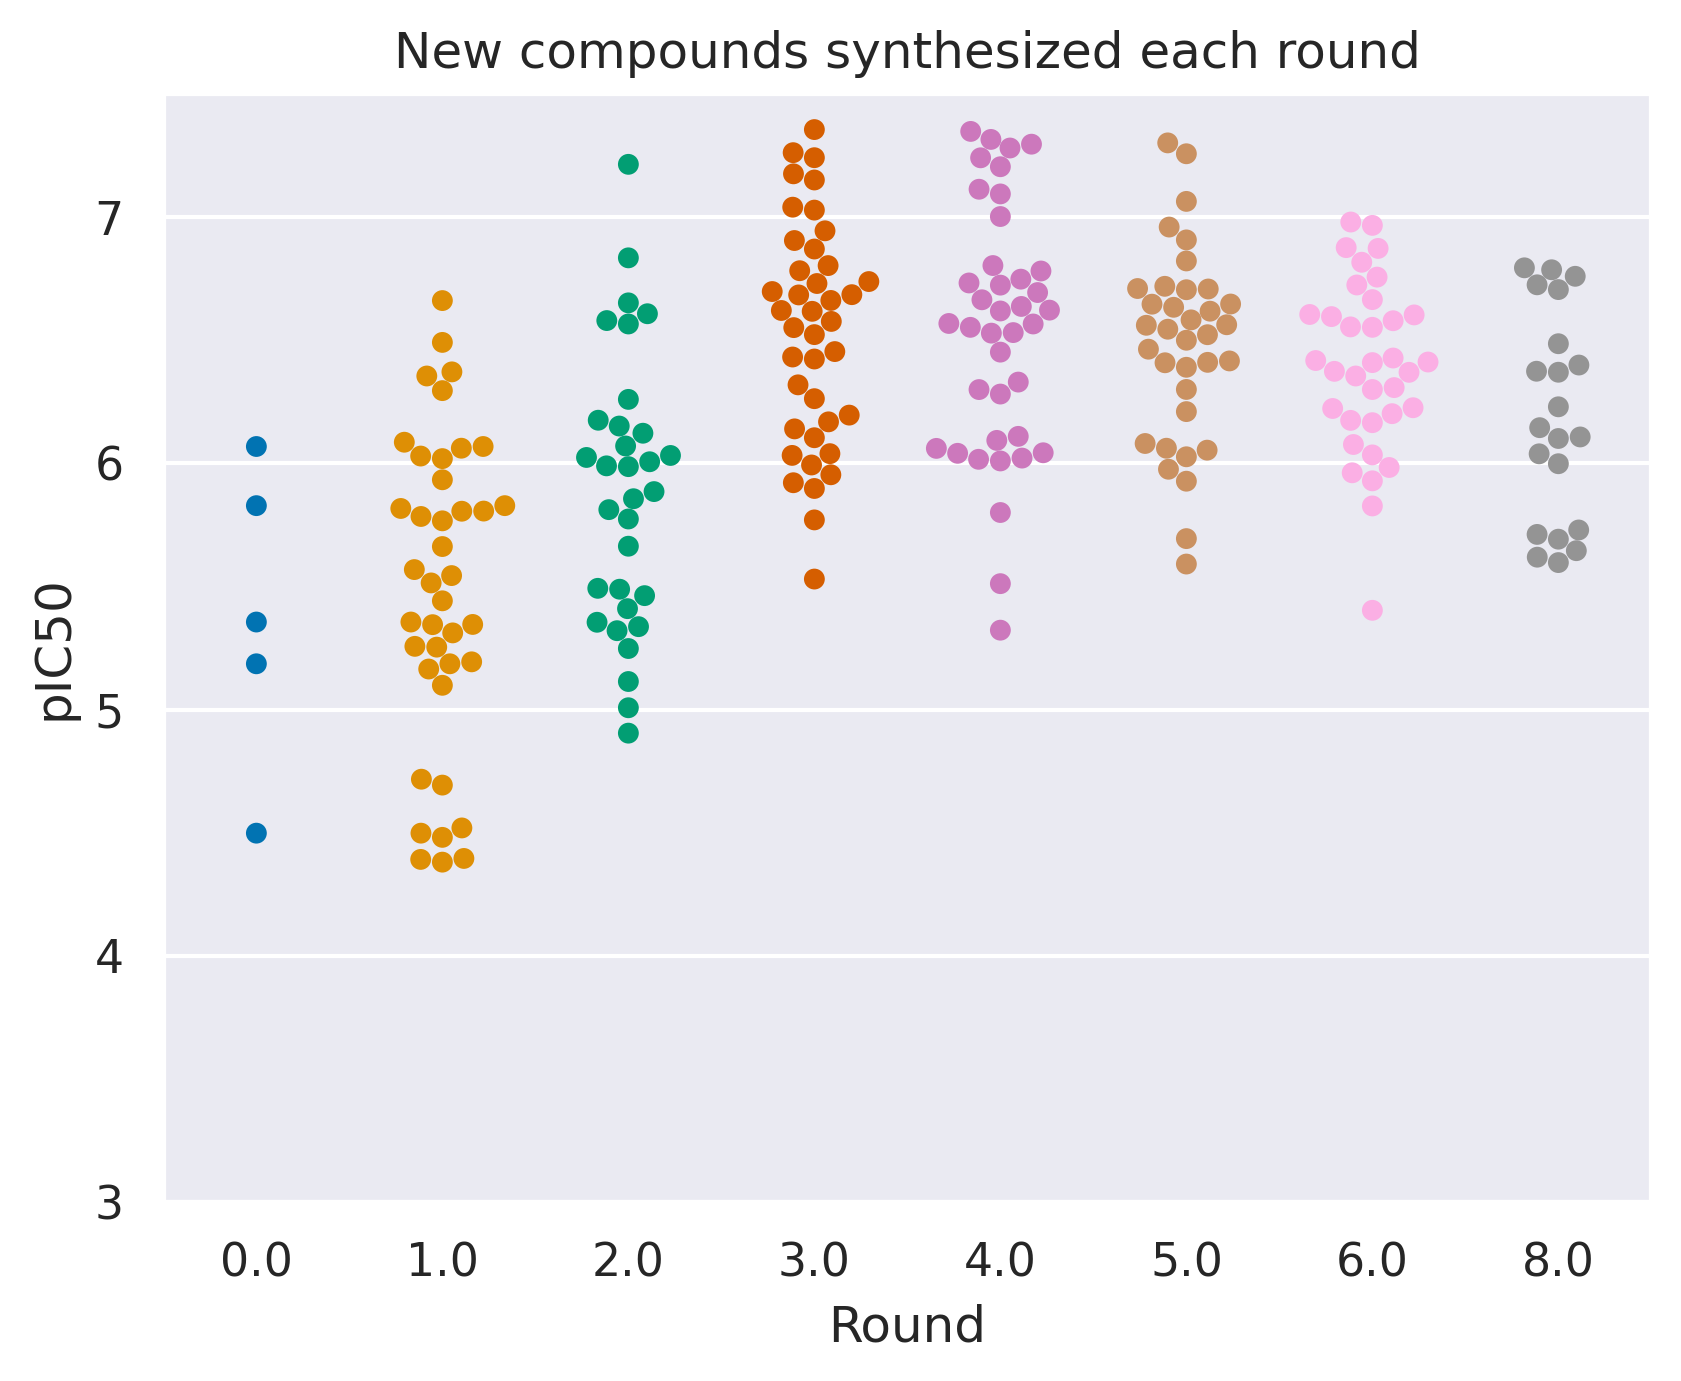

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(dpi=300)
sns.set()

objective = f'{name} affinity'
annotations = library.annotations[[f'{name} affinity', 'MolLogP', 'Log S', 'timestep']]
annotations = annotations.map(lambda x: x[0] if isinstance(x, list) else x)
annotations = annotations.dropna()

sns.swarmplot(
    annotations,
    x='timestep',
    y=objective,
    hue='timestep',
    palette='colorblind',
    # complementary=True,
    legend=False
)

plt.ylim(3)
plt.ylabel('pIC50')
plt.xlabel('Round')
plt.title('New compounds synthesized each round')

In [41]:
max_timestep = int(library.annotations.timestep.max())

records = []
for timestep, group in library.annotations.groupby('timestep'):
    for _, mol in group.iterrows():
        record = {'pIC50': mol[f'{name} affinity'][0], 'timestep': timestep}
        records.append(record)
        
        # Duplicate logic for each possible timestep
        for t in range(1, max_timestep + 1):
            if timestep < t:
                records.append({**record, 'timestep': t})

df = pd.DataFrame(records)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

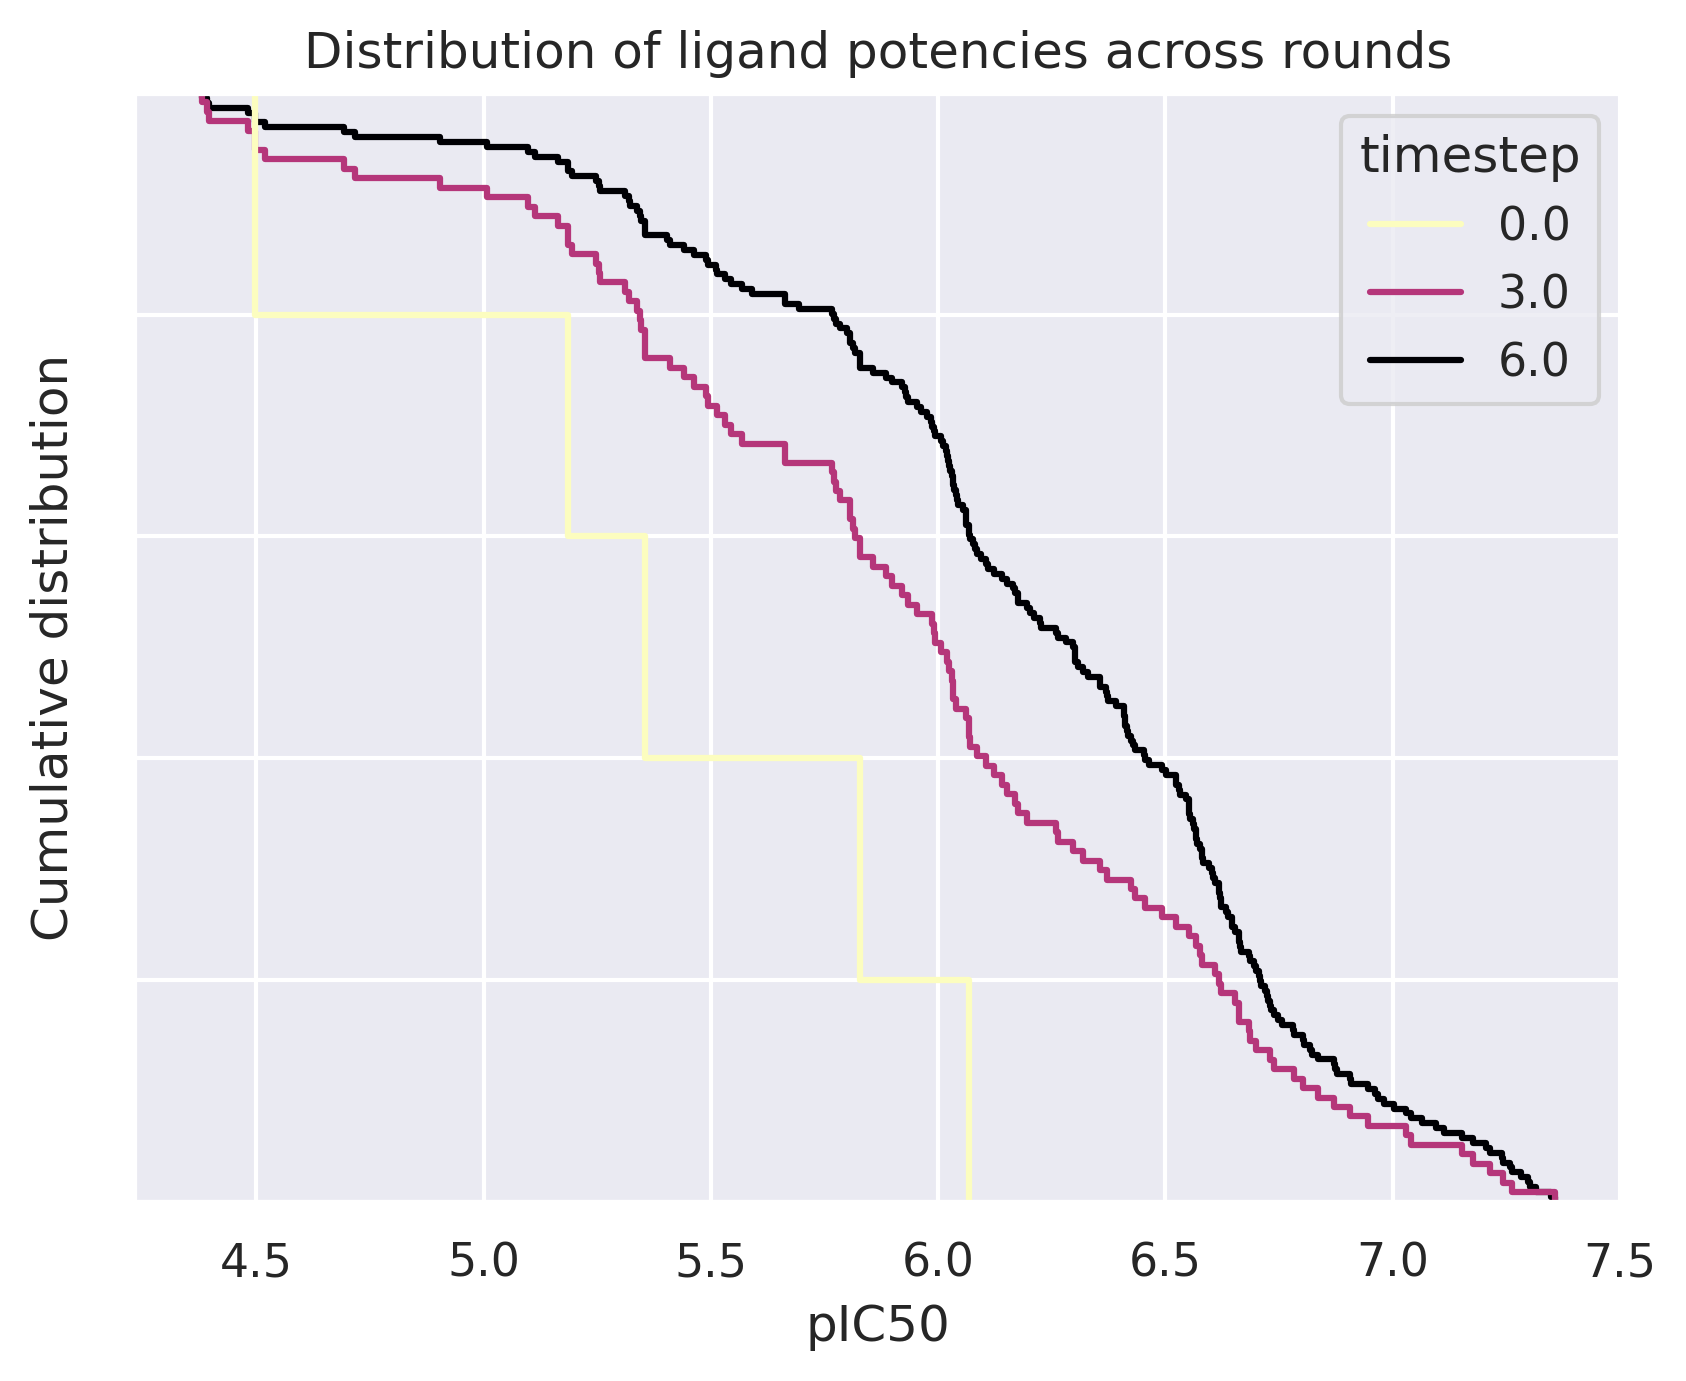

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(dpi=300)

g = sns.ecdfplot(
    df.query('timestep % 3 == 0'),
    x='pIC50',
    hue='timestep',
    palette='magma_r',
    complementary=True
)

g.set(yticklabels=[])

plt.xlabel('pIC50')
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

Text(0.5, 1.0, 'Assay values across time')

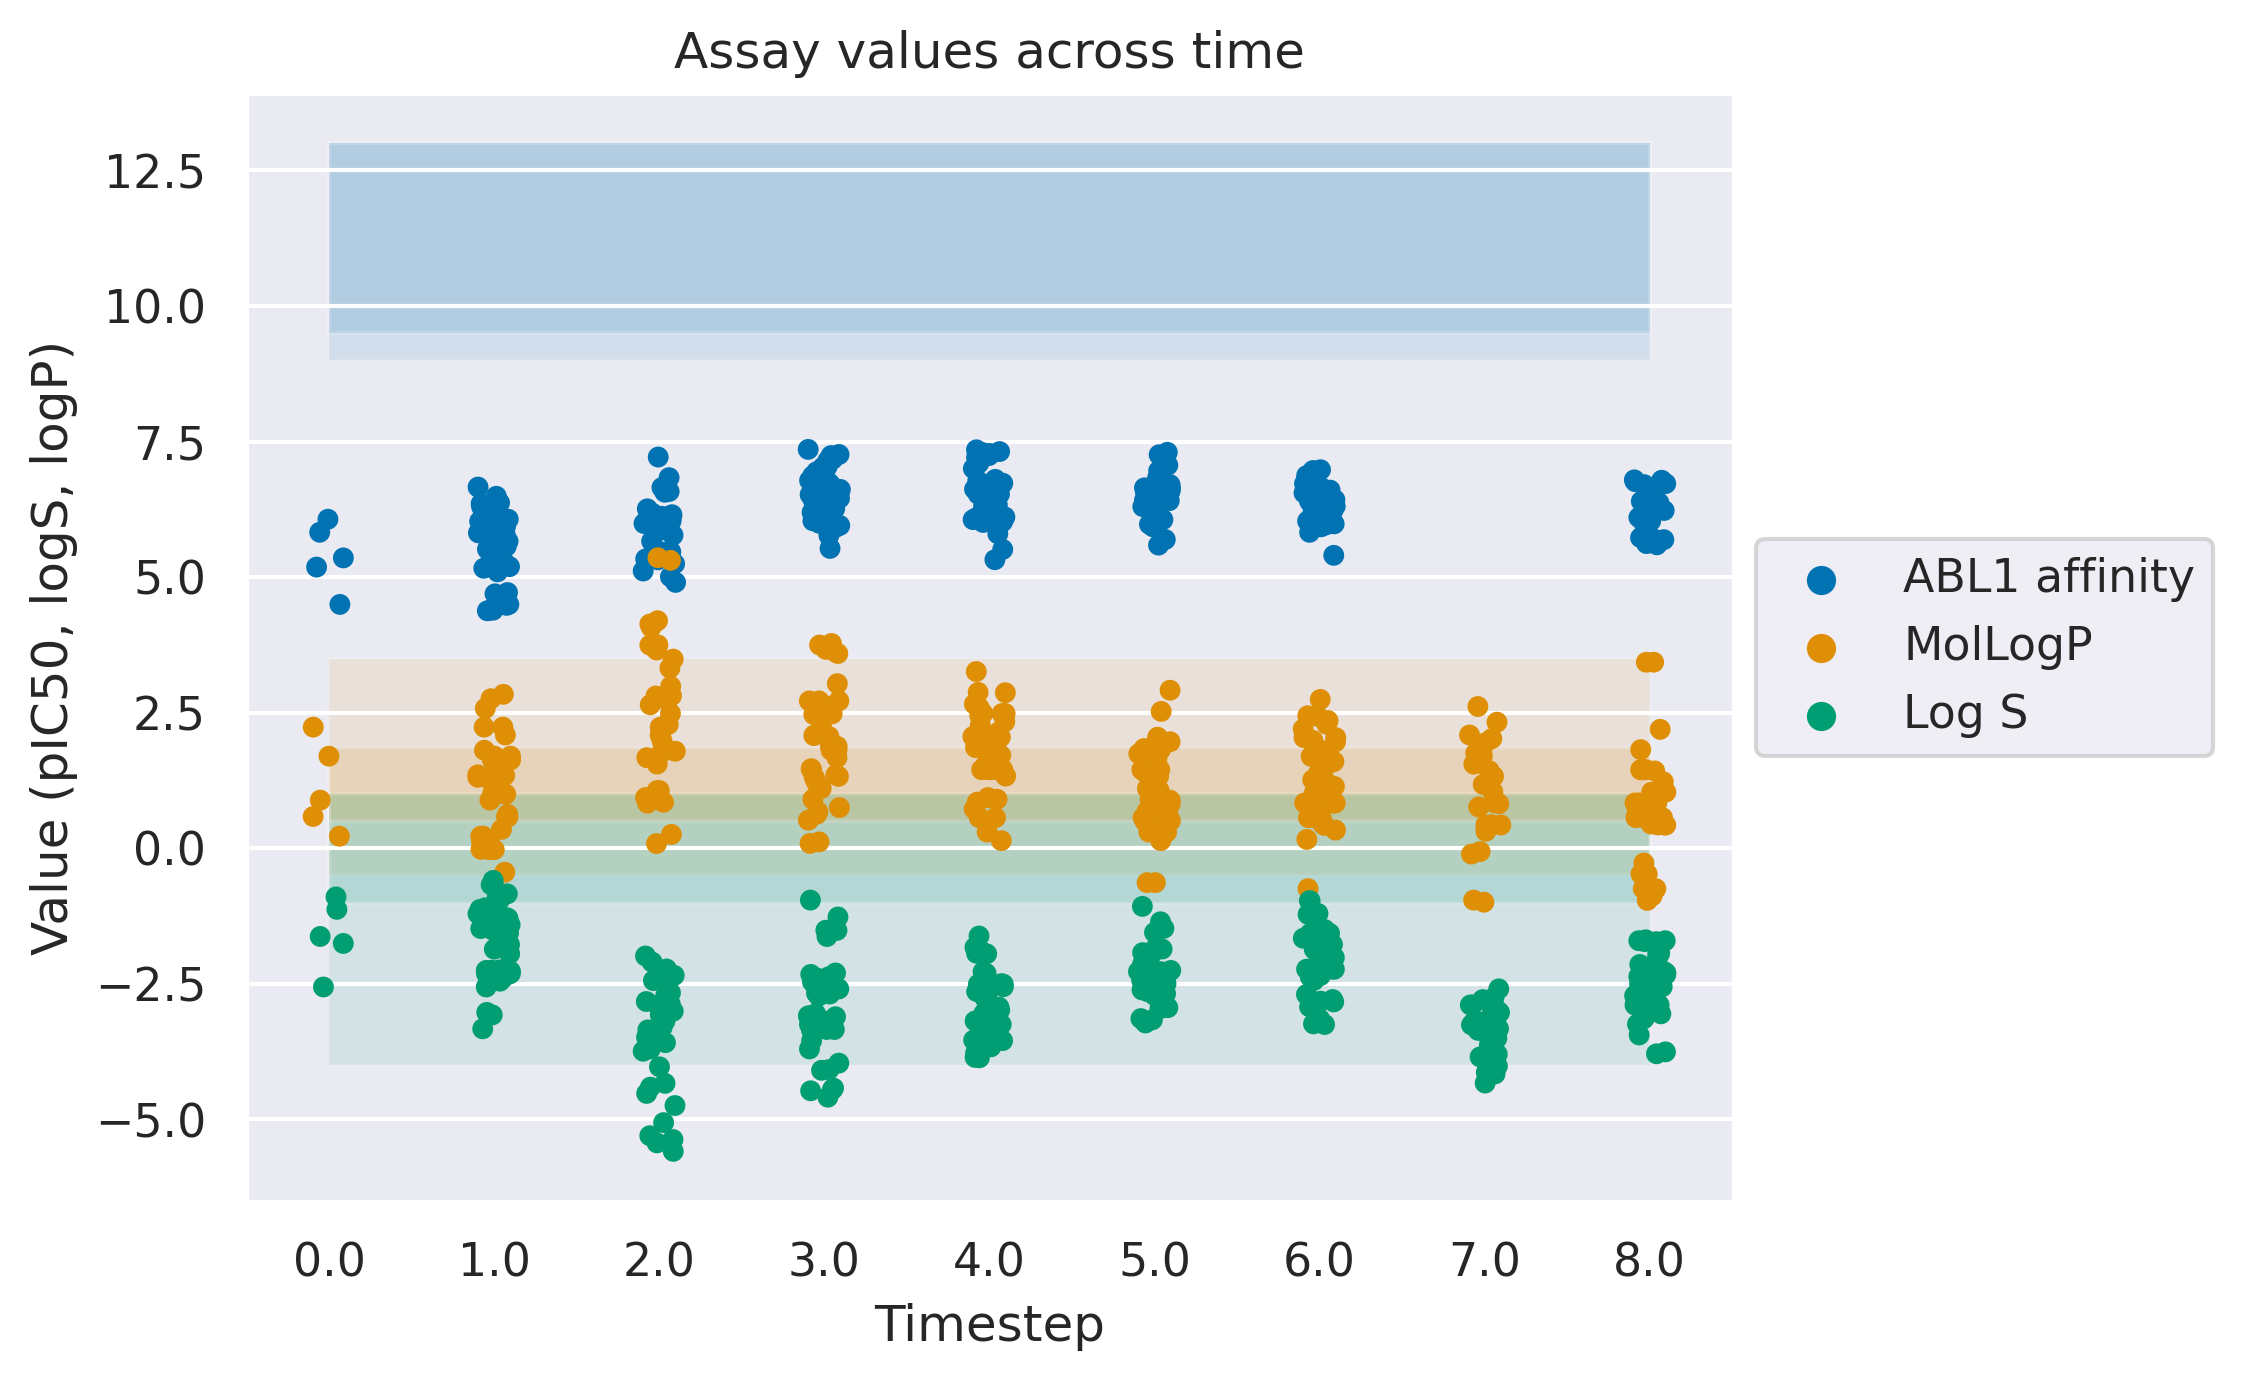

In [44]:
plt.figure(dpi=300)
sns.set_theme()

annotations = (
    library.annotations
    .map(lambda x: x[0] if isinstance(x, list) else x)
    [['timestep', f'{name} affinity', 'MolLogP', 'Log S']]
)

annotations = pd.melt(
    annotations,
    id_vars=['timestep'],
    var_name='assay',
    value_name='value'
)

g = sns.stripplot(
    annotations,
    x='timestep',
    y='value',
    hue='assay',
    palette='colorblind'
)

plt.fill_betweenx(
    log_S_cost_function.acceptable, 0, annotations.timestep.max(), alpha=0.1, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[2]
)
plt.fill_betweenx(
    log_P_cost_function.acceptable, 0, annotations.timestep.max(), alpha=0.1, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[1]
)
plt.fill_betweenx(
    docking_cost_function.acceptable, 0, annotations.timestep.max(), alpha=0.1, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[0]
)

plt.fill_betweenx(
    log_S_cost_function.ideal, 0, annotations.timestep.max(), alpha=0.15, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[2]
)
plt.fill_betweenx(
    log_P_cost_function.ideal, 0, annotations.timestep.max(), alpha=0.15, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[1]
)
plt.fill_betweenx(
    docking_cost_function.ideal, 0, annotations.timestep.max(), alpha=0.15, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[0]
)

g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Timestep')
plt.ylabel('Value (pIC50, logS, logP)')
plt.title('Assay values across time')

In [454]:
# from radar import radar_chart
# import matplotlib.pyplot as plt

# annotations = (
#     library.annotations.map(
#     lambda x: x[0] if isinstance(x, list) else x)
#     [['CASP3 affinity', 'MolLogP', 'Log S']]
# )

# labels = annotations.columns
# values = annotations.iloc[0]

# radar_chart(
#     labels=labels, values=values, fill_alpha=0)
# plt.show()

Docking on-disk.

In [554]:
results = docking_oracle(
    milestones,
    # path='../../dgym-data/out/docking_results',
    use_cache=False
)
results

[7.433781982051665,
 7.214740744254979,
 5.9216029919948285,
 7.099476037309046,
 7.158640013161654,
 7.911241073074357,
 6.018506219176501,
 7.609382057070857]

# Testing replicability of docking results

In [ ]:
r1 = docking_oracle(subset, use_cache=False)
r2 = docking_oracle(subset, use_cache=False)

In [ ]:
pd.DataFrame([r1, r2]).T.corr()

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'ABL1 affinity (Replicate 2) | Reset Cache')

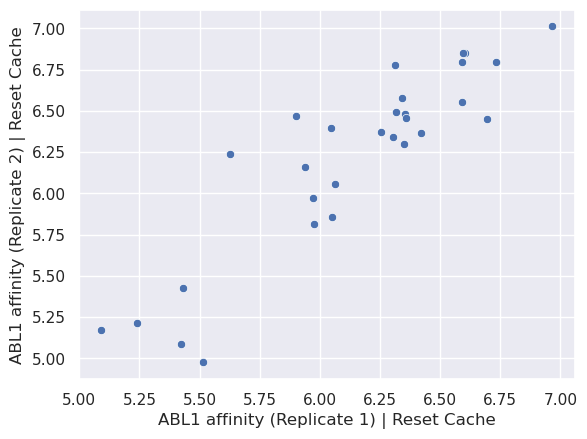

In [67]:
docking_oracle.reset_cache()
sns.scatterplot(
    x=r1,
    y=r2
)

plt.xlabel('ABL1 affinity (Replicate 1) | Reset Cache')
plt.ylabel('ABL1 affinity (Replicate 2) | Reset Cache')

In [45]:
subset = library[::9]
# all_results = []
# for _ in tqdm(range(10)):
#     all_results.append(docking_oracle(subset, use_cache=False))

Text(0, 0.5, 'ABL1 affinity (Replicate 2)')

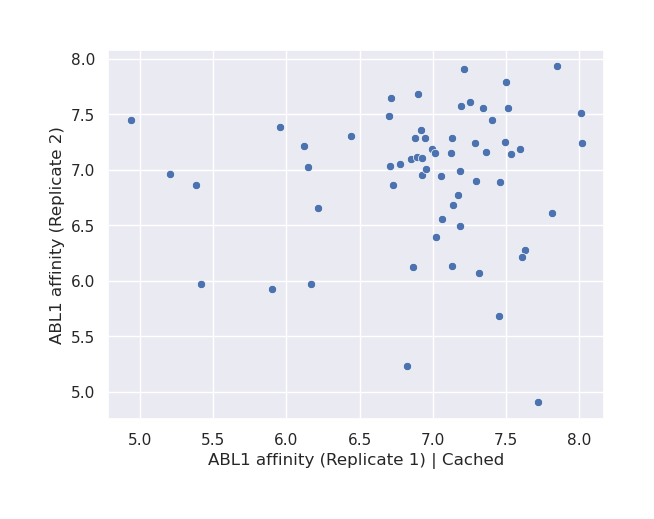

In [1133]:
docking_oracle.reset_cache()
sns.scatterplot(
    x=docking_oracle(subset, use_cache=True),
    y=docking_oracle(subset, use_cache=False)
)

plt.xlabel('ABL1 affinity (Replicate 1) | Cached')
plt.ylabel('ABL1 affinity (Replicate 2)')

In [1142]:
subset.smiles[0], y[0]

('Fc1cccc(CN2CCOCC2)c1', 6.1138199445935575)

In [1182]:
idx = 6
docking_oracle.cache[subset[12].smiles], y[idx]

(6.443315719259864, 7.350846626380774)

In [1198]:
from scipy.stats import pearsonr

pearsonr(
    all_results[0],
    y
)

PearsonRResult(statistic=0.9342964467063766, pvalue=1.4551670474160733e-28)

In [1208]:
docking_oracle(subset[0])

[5.880575740041292]

In [1278]:
(abs(np.array(res) - y) < 0.8).sum()

46

In [1294]:
(abs(np.random.permutation(all_results[2]) - y) < 0.8).sum()

42

In [1301]:
pearsonr(all_results[2], y)

PearsonRResult(statistic=0.9003664666008347, pvalue=2.3566815325144693e-23)

In [1296]:
docking_oracle = docking_oracle.reset_cache()
preds, cached_preds = docking_oracle(subset, use_cache=True)

In [1339]:
list(zip([s.smiles for s in set(subset)], preds))[0]

('CC1COC(Cn2cc(CCCCN3CCN(c4ccccc4O)CC3)nn2)CN1C(=O)[C@@H](C)ON',
 7.226298902653257)

In [1343]:
ordering = [subset.smiles.index(s.smiles) for s in set(subset)]

In [1356]:
pearsonr(y, np.array(preds)[ordering])

PearsonRResult(statistic=0.1793675028310813, pvalue=0.1630337284828524)

In [1311]:
test = dict(zip([s.smiles for s in set(subset)], preds))
pearsonr([test[s.smiles] for s in subset], y)

PearsonRResult(statistic=-0.2457833612325116, pvalue=0.05415864061376777)

In [1203]:
# [s.smiles for s in set(subset)]

In [1145]:
cache = dict(zip(subset.smiles, y))
np.array([cache[m.smiles] for m in subset]) == y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [635]:
df = (
    pd.DataFrame(
        np.array(all_results)
    )
    .stack()
    .reset_index()
    .set_axis(['trial', 'molecule', 'affinity'], axis=1)
)

df.groupby('molecule')[['affinity']].agg(['mean', 'std']).affinity

,mean,std
molecule,,
0,6.160128,0.134629
1,7.429822,0.179302
2,6.882847,0.343556
3,7.430475,0.109829
4,7.105105,0.172657
...,...,...
57,5.101818,0.210544
58,7.471555,0.161099
59,6.906644,0.216955


Text(0.5, 1.0, 'Sample of molecule affinities (10 replicates)')

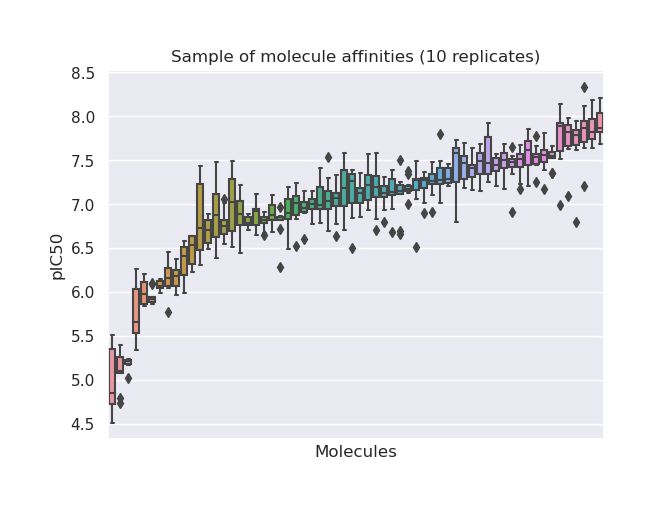

In [1121]:
ranks = np.quantile(all_results, axis=0, q=0.25).argsort()
sns.boxplot(
    df,
    x='molecule',
    y='affinity',
    order=ranks
)

plt.xticks([])
plt.xlabel('Molecules')
plt.ylabel('pIC50')
plt.title('Sample of molecule affinities (10 replicates)')

Manual selection experiments.

In [733]:
mol = next(designer.construct_reaction({'product': 'O=C(c1ccc([C@@H]2Nc3c(Cl)cc(Cl)cc3[C@@H]3C=CC[C@@H]32)cc1)N1CC2C(C1)C(F)(F)C(F)(F)C(F)(F)C2(F)F',
 'reaction': '83_Schotten_Baumann_amide',
 'reactants': [{'product': 'Cl.FC1(F)C2CNCC2C(F)(F)C(F)(F)C1(F)F'},
  {'product': 'O=C(O)c1ccc([C@@H]2Nc3c(Cl)cc(Cl)cc3[C@@H]3C=CC[C@@H]32)cc1'}]}))

In [757]:
res = docking_oracle([mol]*10, use_cache=False)
np.mean(res), np.std(res)

(8.678624135794863, 0.9941671891728934)

In [837]:
res = docking_oracle([analogs[24]]*10, use_cache=False)
np.mean(res), np.std(res)

(8.680068838809783, 0.31056034435041263)

In [841]:
[c(analogs[24]) for c in assays]

[[8.051624498638573], [3.7162000000000024], [-3.7385374571956023]]

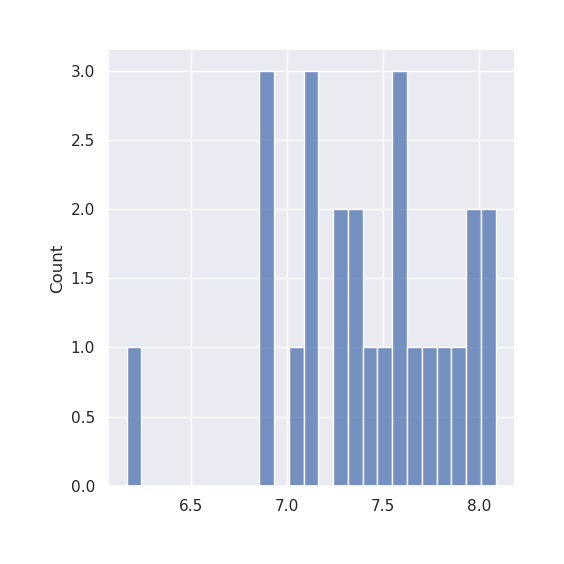

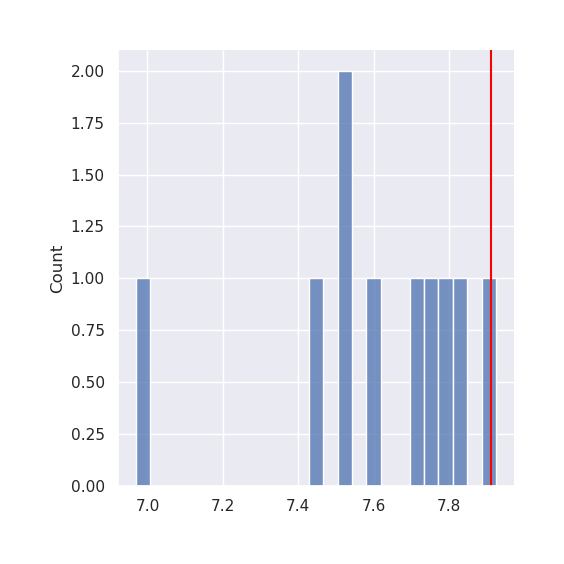

In [852]:
starting_point = library[477]
starting_point_replicates = docking_oracle([starting_point]*10, use_cache=False)

analogs = designer.design(
    starting_point, 25, strategy='replace', temperature=0.0)
analog_docking_scores = docking_oracle(analogs, use_cache=False)

sns.displot(analog_docking_scores, bins=25)
sns.displot(starting_point_replicates, bins=25)
plt.axvline(docking_oracle(library[477]), color='red')